# Single Particle in a Constant Electric Field

## Introduction
In this tutorial, we will simulate the motion of a single charged particle in a linearly increasing electric field using **PlasmaTorch**. Our goal is to verify that the particle's velocity increases approximately linearly over time when subjected to a constant acceleration.

### Physical Background
A charged particle (with charge q and mass m) in a uniform electric field \(\mathbf{E}\) experiences a constant force:
$$
  \mathbf{F} = q \mathbf{E}
$$
If the field is constant or varies linearly in space (such that the force on the particle is still effectively constant while it moves in the domain), then the acceleration \(\mathbf{a} = \mathbf{F} / m\) is constant. Consequently, the velocity \(\mathbf{v}(t)\) should increase linearly in time:
$$
  \mathbf{v}(t) = \mathbf{v}_0 + \mathbf{a} t
$$
In our setup, we impose a linearly increasing potential in the \(x\)-direction, which corresponds to a constant (or nearly constant) electric field. We place a single test particle (mass = 1, charge = 1) in the center of the domain and observe its motion.

## Cell 1: Imports, Device Setup, and Basic Configurations
In this cell, we:
- Enable automatic reloading of modules with `%autoreload`.
- Import necessary libraries, including **torch**, **matplotlib**, **numpy**, and various **PlasmaTorch** modules.
- Add local paths for **PlasmaTorch** imports.
- Automatically detect and set the computing device (`cuda` if available, otherwise `cpu`).
- Fix a random seed for reproducibility.

In [ ]:
%load_ext autoreload
%autoreload 2

import torch
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import torch.autograd.profiler as profiler
from scipy.constants import *
import sys
sys.path.append("../")
sys.path.append("../plasmatorch")

from plasmatorch.simulator import *
from plasmatorch.utils import *
from plasmatorch.deposition import *
from plasmatorch.fields import *
from plasmatorch.helper import *

device = "cuda" if torch.cuda.is_available() else "cpu"
set_seed(2304)

## Cell 2: Defining the Simulation and Creating a Single Test Particle
Here, we:
- Define the simulation box size (\(L_x, L_y\)) and a grid resolution of 32 × 32.
- Set a relatively large time step (`dt = 1e-5`) and total simulation time (`simulation_time = 1e-2`).
- Initialize a **PlasmaTorch** simulation with reflecting boundaries.
- Create one particle named `test_particle` at the center (0.5, 0.5), with mass 1 and charge 1.
- Define a linearly increasing potential in the x-direction. The `linear_potential` array is assigned to the simulation domain by calling `add_rectangle_object()` with the argument `solid=False` so that it acts as a field rather than a solid object.

Because of this linear potential, the particle will experience a constant electric field (assuming the potential is linear along the x-direction), which should accelerate it steadily.

In [10]:
Lx, Ly = 1.0, 1.0
Nx, Ny = 32, 32
dt = 1e-5
simulation_time = 1e-2
normalization = 1.0
simulation_name = "Test"

backend = "cpu"

sim = PlasmaTorch(
    simulation_name=simulation_name,
    Lx=Lx,
    Ly=Ly,
    Nx=Nx,
    Ny=Ny,
    simulation_time=simulation_time,
    dt=dt,
    boundaries_type="reflecting",
    save_frequency=10,
    backend= backend,
)

sim.poisson_method = "gauss_seidel"

# Create one particle with q = 1, m = 1
sim.create_new_specie(
    name="test_particle",
    num_particles=1,
    distribution="zero",
    disposition="specific",
    position=[0.5, 0.5],
    mass=1.0,
    charge=1.0
)

E0 = 1000  # potential difference along the x-direction
linear_potential = torch.zeros((Nx, Ny))
for j in range(Ny):
    linear_potential[j, :] = torch.linspace(0, E0, Nx)

sim.add_rectangle_object(0, Lx, 0, Ly, solid=False, potential=linear_potential)

steps = sim.steps
with torch.no_grad():
    for step in tqdm(range(steps), unit=" step", leave=True):
        sim.update()

# Print the final velocity of the particle
v_final = sim.particles_velocity[0]
print("Velocità finale della particella:", v_final.cpu().numpy())

100%|██████████| 999/999 [00:02<00:00, 363.73 step/s]

Velocità finale della particella: [  0.       -10.312249   0.      ]


## Cell 3: Reloading the Simulation
If the simulation results have been saved, we can reload them with **`load_simulation()`**. This allows further post-processing without needing to re-run the entire simulation.

In [11]:
simulation = load_simulation(simulation_name, device= backend)

[INFO] Loaded datasets from Test: ['charge_register', 'fields_chronology', 'fixed_potential_mask', 'fixed_potential_value', 'grid_chronology', 'kinetic_energy_chronology', 'mass_register', 'mechanic_energy_chronology', 'particles_active_chronology', 'particles_position_chronology', 'particles_specie_chronology', 'particles_velocity_chronology', 'potential_energy_chronology', 'solid_mask', 'solid_type']


## Cell 4: Plotting Velocity over Time
We extract the velocity history from `simulation['particles_velocity_chronology']`. Since there is only one particle, we can directly take `velocities[:, 0, :]`. We split it into `vx` and `vy` components and plot them to observe how the particle velocity evolves.

We expect the particle to primarily accelerate in the x-direction (due to the linear potential). The y-component should stay near zero if there are no other forces in the y-direction.

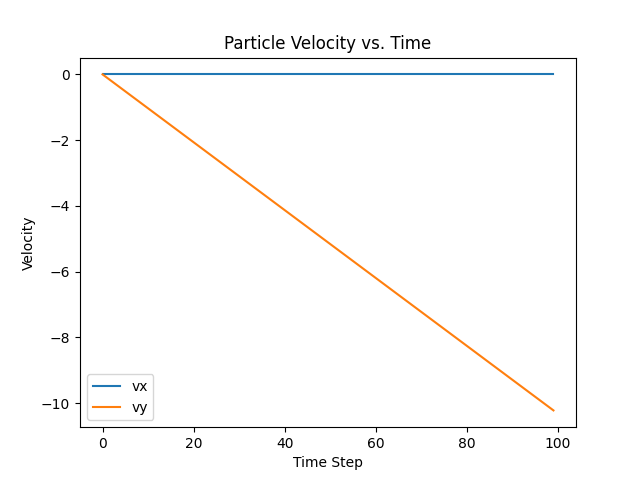

In [12]:
plt.figure()
velocities = np.array(simulation['particles_velocity_chronology'][:])
vx = velocities[:, 0, 0]
vy = velocities[:, 0, 1]
plt.plot(vx)
plt.plot(vy)
plt.legend(["vx", "vy"], loc="best")
plt.title("Particle Velocity vs. Time")
plt.xlabel("Time Step")
plt.ylabel("Velocity")
plt.show()

## Cell 5: Interactive Visualization with `dynamic_slider`
Finally, we can use the `%matplotlib widget` backend to explore the trajectory of our single particle over time. This will display the particle's position at each saved time step and allow us to animate by moving the slider.

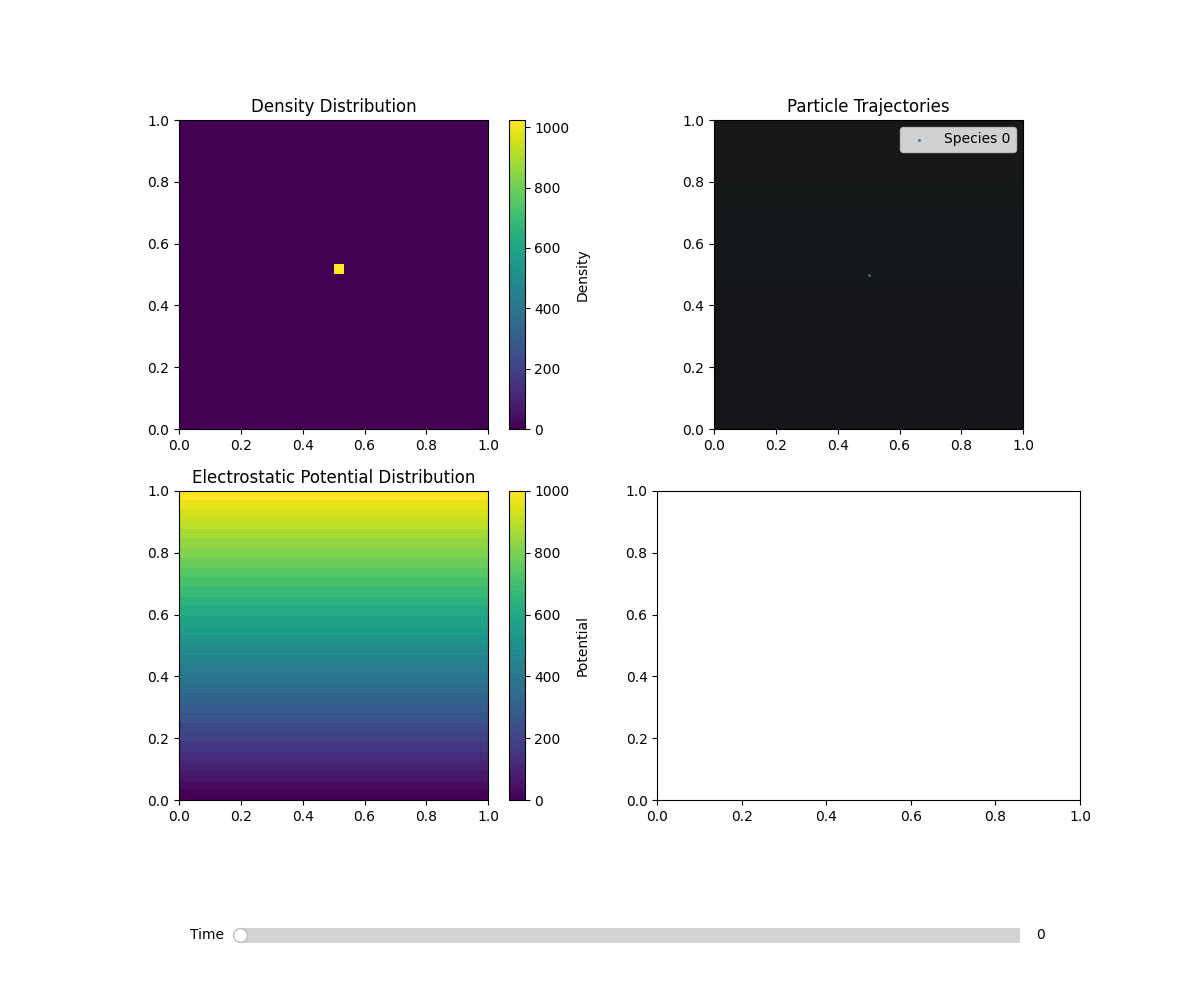

AttributeError: 'Canvas' object has no attribute 'key_press_event'

AttributeError: 'Canvas' object has no attribute 'key_press_event'

AttributeError: 'Canvas' object has no attribute 'key_release_event'

AttributeError: 'Canvas' object has no attribute 'key_press_event'

AttributeError: 'Canvas' object has no attribute 'key_release_event'

AttributeError: 'Canvas' object has no attribute 'key_release_event'

AttributeError: 'Canvas' object has no attribute 'key_press_event'

AttributeError: 'Canvas' object has no attribute 'key_press_event'

AttributeError: 'Canvas' object has no attribute 'key_release_event'

AttributeError: 'Canvas' object has no attribute 'key_release_event'

In [13]:
%matplotlib widget

dynamic_slider(simulation, Lx, Ly)

## Conclusion
In this tutorial, we verified that a single particle subjected to a linearly increasing electric potential (and thus an approximately constant electric field) experiences a constant acceleration in the x-direction. The velocity profile should be nearly linear in time, confirming that the force \(qE\) on the particle produces uniform acceleration when mass and charge are constant.
This approach can be extended to more complex potential landscapes or additional particles, allowing you to explore self-consistent field effects and collisions in future simulations.